In [203]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import mne

import glob
import os
import sys
from scipy.io import savemat, loadmat

sys.path.append('../utils')
from ERP_utils import *
from update_sub_lists import*

### TO DO: 

make this notebook handle the pre and post data at once without manually setting the period each time
also different musician levels

### Set up 

In [204]:
#-----------------------------
#           LOADING FILES AND INITIALIZING DIRECTORIES
#-----------------------------
evoked_dir = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_ERP_data'
epochs_dir = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data'
figs_dir = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/figures'


#channels and times for plotting
ch_names_64, ch_names_72 = load_channels()
erp_times = load_erp_times()

good_listen_subjects, good_motor_subjects, musicians, nonmusicians = load_subject_lists()
subjects_to_process = good_motor_subjects
good_motor_subjects.remove('03') #error data looks bad

#some promising differences when including just musicians (subjects 5,6,7)


In [205]:
def load_error_epochs_bysubject(subjects_to_process, epoch_type):
    """ 
    Loads the epochs for error trials
    subjects_to_process: list of subjects where each element is a string. e.g. ['01', '02']
    epoch_type: which error keystrokes are included. Currently 'all', 'inv', 'shinv' and 'norm'
        ---future: separate keystrokes that are the first keystroke after a map change from all the other keystrokes
    ---
    Returns a dataframe with columns 'subject', 'period', 'musician', and 'epoch_type'.
        each row of ['epochs'] is an array of shape n_channels x n_timepoints, and is the average of all epochs from one subject
    
    """

    epochs_dir = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data'
    epochs_df = pd.DataFrame(columns = ['subject', 'period', 'musician', 'epochtype', 'epochs'])
    good_listen_subjects, good_motor_subjects, musicians, nonmusicians = load_subject_lists()

    assert isinstance (subjects_to_process, list)

    for subject in subjects_to_process:
        print('Processing subject: ', subject)

        if subject in musicians: 
            musician = 1
        else: 
            musician = 0
        for period in ['pre', 'post']:
            file_epochs_pre = glob.glob(os.path.join(epochs_dir, f'error_epochs_{epoch_type}_{period}_{subject}.fif'))[0]
            epochs_sub = mne.read_epochs(file_epochs_pre)
            epochs_sub = np.mean(epochs_sub.get_data()[:, :64, :], axis = 0) #get only the eeg channels and average all trials per subject
            #epochs_sub = epochs_sub[np.newaxis, :, :]

            df_sub = pd.DataFrame({
                'subject': subject,
                'period' : period,
                'musician' : musician,
                'epochtype': epoch_type,
                'epochs': [epochs_sub]
            })
            epochs_df = pd.concat([epochs_df, df_sub])


    epochs_df.reset_index(drop=True, inplace=True)
    return (epochs_df)


In [236]:
epochs_df_all = load_error_epochs_bysubject(subjects_to_process, 'all')
epochs_df_inv = load_error_epochs_bysubject(subjects_to_process, 'inv')
epochs_df_shinv = load_error_epochs_bysubject(subjects_to_process, 'shinv')
epochs_df_norm = load_error_epochs_bysubject(subjects_to_process, 'norm')


Processing subject:  01
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_all_pre_01.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
289 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_all_post_01.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
390 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  04
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_all_pre_04.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices availa

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_32163/2201164840.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_all_pre_01.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_32163/2201164840.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_all_post_01.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_32163/2201164840.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epo

Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_all_post_07.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
308 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  08
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_all_pre_08.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
267 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_all_post_08.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadat

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_32163/2201164840.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_all_post_07.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_32163/2201164840.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_all_pre_08.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_32163/2201164840.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epo

Not setting metadata
251 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  11
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_all_pre_11.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
403 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_all_post_11.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
459 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  12
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_all_pre_12.fif ...
    Foun

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_32163/2201164840.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_all_pre_11.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_32163/2201164840.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_all_post_11.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_32163/2201164840.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epo

    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
479 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_all_post_15.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
517 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  16
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_all_pre_16.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
392 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Au

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_32163/2201164840.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_all_post_15.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_32163/2201164840.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_all_pre_16.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_32163/2201164840.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epo

Processing subject:  19
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_all_pre_19.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
395 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_all_post_19.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
424 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  20
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_all_pre_20.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices availa

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_32163/2201164840.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_all_pre_19.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_32163/2201164840.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_all_post_19.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_32163/2201164840.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epo

    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
186 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_inv_post_06.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
189 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  07
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_inv_pre_07.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
186 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Au

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_32163/2201164840.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_inv_post_06.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_32163/2201164840.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_inv_pre_07.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_32163/2201164840.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epo

Not setting metadata
199 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_inv_post_11.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
235 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  12
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_inv_pre_12.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
143 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_inv_post_12.fif ...
    Found the data of interest:

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_32163/2201164840.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_inv_post_11.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_32163/2201164840.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_inv_pre_12.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_32163/2201164840.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epo

Not setting metadata
254 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  16
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_inv_pre_16.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
197 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_inv_post_16.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
133 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  17
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_inv_pre_17.fif ...
    Foun

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_32163/2201164840.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_inv_pre_16.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_32163/2201164840.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_inv_post_16.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_32163/2201164840.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epo

Not setting metadata
96 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  04
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_shinv_pre_04.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_shinv_post_04.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
87 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  05
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_shinv_pre_05.fif ...
    F

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_32163/2201164840.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_shinv_pre_04.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_32163/2201164840.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_shinv_post_04.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_32163/2201164840.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error

        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
95 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  10
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_shinv_pre_10.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
69 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_shinv_post_10.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  11
Reading /Users/cindyzhang/Documents/M2/Audiomoto

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_32163/2201164840.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_shinv_pre_10.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_32163/2201164840.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_shinv_post_10.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_32163/2201164840.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error

Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_shinv_post_15.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  16
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_shinv_pre_16.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
93 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_shinv_post_16.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting me

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_32163/2201164840.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_shinv_post_15.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_32163/2201164840.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_shinv_pre_16.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_32163/2201164840.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error

0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_norm_post_04.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
89 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  05
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_norm_pre_05.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
82 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_norm_post_05.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_32163/2201164840.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_norm_post_04.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_32163/2201164840.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_norm_pre_05.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_32163/2201164840.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_e

    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
79 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_norm_post_10.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  11
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_norm_pre_11.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
108 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Au

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_32163/2201164840.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_norm_post_10.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_32163/2201164840.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_norm_pre_11.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_32163/2201164840.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_e

Not setting metadata
140 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  16
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_norm_pre_16.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
103 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_norm_post_16.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  17
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_norm_pre_17.fif ...
    Fo

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_32163/2201164840.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_norm_pre_16.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_32163/2201164840.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data/error_epochs_norm_post_16.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_32163/2201164840.py:28: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_e

In [241]:
# ARRANGE EPOCHS INFO INTO A DICTIONARY

# Define dataset names and conditions
datasets = {
    'all': epochs_df_all,
    'inv': epochs_df_inv,
    'shinv': epochs_df_shinv,
    'norm': epochs_df_norm
}
periods = ['pre', 'post']
musician_status = {
    'mus': 'musician == 1',
    'nmus': 'musician == 0'
}

# Initialize dictionary
epochs_dict = {}

# Loop through datasets, periods, and musician status
for dataset_name, dataset in datasets.items():
    for period in periods:
        for mus, condition in musician_status.items():
            key = f'{dataset_name}_{period}_{mus}'
            query_str = f"period == '{period}' and {condition}"
            epochs_dict[key] = np.array(dataset.query(query_str)['epochs'].tolist())


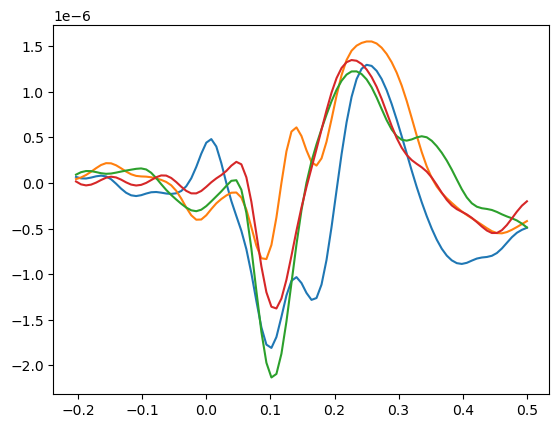

In [248]:
#average over all subjects and channels

all_pre_mus_ave = np.mean(epochs_dict['all_pre_mus'], axis = (0,1)) 
all_post_mus_ave = np.mean(epochs_dict['all_post_mus'], axis = (0,1)) 
all_pre_nmus_ave = np.mean(epochs_dict['all_pre_nmus'], axis = (0,1)) 
all_post_nmus_ave = np.mean(epochs_dict['all_post_nmus'], axis = (0,1)) 


plt.plot(erp_times, all_pre_mus_ave)
plt.plot(erp_times, all_post_mus_ave)
plt.plot(erp_times, all_pre_nmus_ave)
plt.plot(erp_times, all_post_nmus_ave)

In [251]:
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate SEM
def sem(data, axis=0):
    return np.std(data, axis=axis) / np.sqrt(data.shape[axis])

# Calculate mean and SEM for all conditions
all_pre_mus_ave = np.mean(epochs_dict['all_pre_mus'], axis=(0,1))
all_post_mus_ave = np.mean(epochs_dict['all_post_mus'], axis=(0,1))
all_pre_nmus_ave = np.mean(epochs_dict['all_pre_nmus'], axis=(0,1))
all_post_nmus_ave = np.mean(epochs_dict['all_post_nmus'], axis=(0,1))

# SEM calculations
all_pre_mus_sem = sem(epochs_dict['all_pre_mus'], axis=(0,1))
all_post_mus_sem = sem(epochs_dict['all_post_mus'], axis=(0,1))
all_pre_nmus_sem = sem(epochs_dict['all_pre_nmus'], axis=(0,1))
all_post_nmus_sem = sem(epochs_dict['all_post_nmus'], axis=(0,1))

# Plot mean and SEM
plt.figure(figsize=(10, 6))

# Plot with SEM shading for musicians
plt.plot(erp_times, all_pre_mus_ave, label='Pre Musicians', color='blue')
plt.fill_between(erp_times, all_pre_mus_ave - all_pre_mus_sem, all_pre_mus_ave + all_pre_mus_sem, color='blue', alpha=0.3)

plt.plot(erp_times, all_post_mus_ave, label='Post Musicians', color='green')
plt.fill_between(erp_times, all_post_mus_ave - all_post_mus_sem, all_post_mus_ave + all_post_mus_sem, color='green', alpha=0.3)

# Plot with SEM shading for non-musicians
plt.plot(erp_times, all_pre_nmus_ave, label='Pre Non-Musicians', color='red')
plt.fill_between(erp_times, all_pre_nmus_ave - all_pre_nmus_sem, all_pre_nmus_ave + all_pre_nmus_sem, color='red', alpha=0.3)

plt.plot(erp_times, all_post_nmus_ave, label='Post Non-Musicians', color='orange')
plt.fill_between(erp_times, all_post_nmus_ave - all_post_nmus_sem, all_post_nmus_ave + all_post_nmus_sem, color='orange', alpha=0.3)

# Customize plot
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (µV)')
plt.title('ERP Averages with SEM for Musicians and Non-Musicians')
plt.legend()
plt.grid(True)

# Show plot
plt.show()


TypeError: tuple indices must be integers or slices, not tuple

### Export epoch data

In [ ]:
"""musicians_pre = np.mean(epochs_df_all.query("period == 'pre' and musician == 1")['epochs'], axis=0)
musicians_post = np.mean(epochs_df_all.query("period == 'post' and musician == 1")['epochs'], axis=0)
nonmusicians_pre = np.mean(epochs_df_all.query("period == 'pre' and musician == 0")['epochs'], axis=0)
nonmusicians_post = np.mean(epochs_df_all.query("period == 'post' and musician == 0")['epochs'], axis=0)

savemat('playing_epochs.mat',{
    'mus_pre': musicians_pre,
    'mus_post': musicians_post,
    'nmus_pre': nonmusicians_pre,
    'nmus_post': nonmusicians_post,
    'fs':128,
    'erp_times': erp_times

})"""

'musicians_pre = np.mean(epochs_df_all.query("period == \'pre\' and musician == 1")[\'epochs\'], axis=0)\nmusicians_post = np.mean(epochs_df_all.query("period == \'post\' and musician == 1")[\'epochs\'], axis=0)\nnonmusicians_pre = np.mean(epochs_df_all.query("period == \'pre\' and musician == 0")[\'epochs\'], axis=0)\nnonmusicians_post = np.mean(epochs_df_all.query("period == \'post\' and musician == 0")[\'epochs\'], axis=0)\n\nsavemat(\'playing_epochs.mat\',{\n    \'mus_pre\': musicians_pre,\n    \'mus_post\': musicians_post,\n    \'nmus_pre\': nonmusicians_pre,\n    \'nmus_post\': nonmusicians_post,\n    \'fs\':128,\n    \'erp_times\': erp_times\n\n})'